In [16]:
from dotenv import load_dotenv

load_dotenv()

True

In [17]:
import os
import shutil
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.docstore.document import Document
from langchain_community.document_loaders import PyPDFLoader, TextLoader
from typing import Literal, Optional

from rag_agent import ChatHistory

# 메모리 컨텍스트 저장 변수
stored_resume: Optional[str] = None
stored_jd: Optional[str] = None
base_chain_inputs: Optional[dict] = None
# RAG 벡터 스토어
vectorstore: Optional[Chroma] = None
# 영속 디렉토리 설정 (환경변수 또는 기본 경로)
persist_directory = os.getenv(
    "CHROMA_DB_PATH",
    os.path.join(os.getcwd(), "rag_agent/vectorstore/chroma_db")
)

chat_history = ChatHistory.get_instance()

# 로컬 파일 시스템에서 context와 회사 자료 자동 로딩
# TODO: RAG PyPDF2 -> langchain vector db
def parse_file_to_text(file_path: str) -> str:
    with open(file_path, "rb") as f:
        content = f.read()
    try:
        return content.decode("utf-8")
    except UnicodeDecodeError:
        if file_path.lower().endswith(".pdf"):
            loader = PyPDFLoader(file_path)
            docs = loader.load()
            return "\n".join(doc.page_content for doc in docs)
        elif file_path.lower().endswith((".docx", ".doc", ".txt")):
            loader = TextLoader(file_path)
            docs = loader.load()
            return "\n".join(doc.page_content for doc in docs)
        else:
            return content.decode("utf-8", errors="ignore")
        
def get_company_info():
    # 회사 자료 검색
    retrieved = vectorstore.similarity_search(stored_jd, k=3)
    company_info = "\n".join([doc.page_content for doc in retrieved])
    # Trim company_info to avoid exceeding model context window
    max_company_info_length = 2000
    if len(company_info) > max_company_info_length:
        company_info = company_info[:max_company_info_length]
    return company_info


base_dir = os.path.join(os.getcwd(), "data")
# 이력서 로딩
resume_dir = os.path.join(base_dir, "resume")
for fname in os.listdir(resume_dir):
    stored_resume = parse_file_to_text(os.path.join(resume_dir, fname))
    break
# JD 로딩
jd_dir = os.path.join(base_dir, "jd")
for fname in os.listdir(jd_dir):
    stored_jd = parse_file_to_text(os.path.join(jd_dir, fname))
    break
# 회사 자료 로딩 및 인덱싱
company_dir = os.path.join(base_dir, "company_infos")
docs = []
for fname in os.listdir(company_dir):
    text = parse_file_to_text(os.path.join(company_dir, fname))
    splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
    for chunk in splitter.split_text(text):
        docs.append(Document(page_content=chunk, metadata={"filename": fname}))
embeddings = OpenAIEmbeddings()
vectorstore = Chroma(
    persist_directory=persist_directory, embedding_function=embeddings
)
stored_company_info = get_company_info()
base_chain_inputs = {
    "resume": stored_resume,
    "jd": stored_jd,
    "company_infos": stored_company_info,
}
if docs:
    texts = [d.page_content for d in docs]
    metadatas = [d.metadata for d in docs]
    vectorstore.add_texts(texts=texts, metadatas=metadatas)
    vectorstore.persist()

22:19:19 [INFO] httpx: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
22:19:20 [INFO] httpx: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [18]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from rag_agent import ChatHistory

class AgentState(TypedDict):
    query: str # 사용자 답변
    answer: str # Agent 답변
    input_type: str # 사용자 답변 유형
    persona_id: str # 페르소나 ID
    route_type: str # routing 결과
    resume: str # 자소서(이력서)
    jd: str # 채용공고
    company: str # 회사정보 (인재상)
    chat_history: ChatHistory # 대화내역
    last_question: str #마지막 질문        

In [19]:
from langgraph.graph import MessagesState
from langgraph.types import Command
from typing import Literal
from langchain_core.messages import HumanMessage
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent
from langchain_community.agent_toolkits.polygon.toolkit import PolygonToolkit
from langchain_community.utilities.polygon import PolygonAPIWrapper

import os

llm = ChatOpenAI(
    api_key=os.getenv("OPENAI_API_KEY"), temperature=0.7, model_name="gpt-4o-mini"
)


In [20]:
classify_agent = create_react_agent(
  llm,
  tools=[],
  prompt=""""
  주어진 입력이 어떤 유형인지 판단하세요: 
  - 질문 요청 (question)
  - 꼬리질문 요청 (followup)
  - 모범 답변 요청 (modelAnswer)
  - 답변 (answer)
  - 그 외 일반 텍스트 (other)

  형식: question, followup, modelAnswer, answer, other 중 하나로만 답하세요.
  """
)

def classify_input(state: AgentState) -> AgentState:
    """
    사용자 입력과, 이전 대화내용을 바탕으로 현재 입력이 어떤 형식인지 분류하고,
    결과를 router node로 전달합니다.
    
    Args:
      state (AgentState): 현재 메시지 상태를 나타내는 객체입니다.
    
    Returns:
      Command: router node로 이동하기 위한 명령을 반환합니다.
    """
    
    result = classify_agent.invoke({ input: state['query'] })
    print("classify_input", result['messages'])
    # 분류 결과 추출 (마지막 메시지의 content가 분류값)
    classification = result['messages'][-1].content.strip()
    
    # 결과 메시지를 업데이트하고 router node로 이동합니다.
    return { 
        "input_type": classification, 
        "resume": stored_resume, 
        "jd": stored_jd,
        "company": stored_company_info,
        "chat_history": chat_history.get_all_history_as_string(),
        "last_question": chat_history.get_question_by_id(
            chat_history.get_latest_question_id()
        )
    }

In [21]:
from rag_agent import PersonaService
from rag_agent.persona.Persona import Persona, PersonaType
from rag_agent.persona.PersonaService import PersonaInput

persona_service = PersonaService.get_instance()
# persona_service.set_context(stored_resume, stored_jd)
# 페르소나 추가 (테스트용)
persona_service.add_persona(
    PersonaInput(
        name="Recruiter",
        type="other",
        interests=["조직 적응력", "인성"],
        communicationStyle="차분하고 상냥한 스타일",
    )
)
persona_service.add_persona(
    PersonaInput(
        name="CTO",
        type="developer",
        interests=["이슈 해결 과정과 Lessons Learned"],
        communicationStyle="불필요한 말은 하지 않음, 합리적이고 이성적인 스타일",
    )
)

def assign_persona_node(state: AgentState) -> AgentState:
    """
    페르소나 할당 node입니다. 주어진 state를 기반으로 assign_persona 에이전트를 호출하고,
    결과를 router node로 전달합니다.

    Args:
        state (AgentState): 현재 메시지 상태 객체.

    Returns:
        Command: router node로 이동 명령을 반환.
    """
    print(state)
    resume = state.get("resume", "")
    jd = state.get("jd", "")
    company = state.get("company", "")
    query = state.get("query", "")
    last_question = state.get("last_question", "")
    persona_id = persona_service.invoke_agent(resume, jd, company, query, last_question)
    print("assign_persona_node", persona_id)
    
    return { "persona_id": persona_id }
    

In [22]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal['generate_question', 'generate_model_answer', 'generate_followup', 'llm'] = Field(
        description="The target for the query to answer"
    )

router_system_prompt = """
You are an expert at routing a user's question to 'generate_question', 'generate_model_answer', 'generate_followup' or 'llm'.
'generate_question' contains information about resume, company, jd.
'generate_model_answer' contains information about last question and context(company, resume, jd).
'generate_followup' contains information about last question and applicant's answer.
if you think the question is not related to either 'generate_question', 'generate_model_answer' or 'generate_followup';
you can route it to 'llm'."""

def router(state: AgentState) -> AgentState:
    """
    주어진 state에서 쿼리를 기반으로 적절한 경로를 결정합니다.

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        Literal['generate_question', 'generate_model_answer', 'generate_followup', 'llm']: 쿼리에 따라 선택된 경로를 반환합니다.
    """
    query = state['query']
    router_prompt = ChatPromptTemplate.from_messages([
        ('system', router_system_prompt),
        ('user', '{query}')
    ])

    structured_router_llm = llm.with_structured_output(Route)

    router_chain = router_prompt | structured_router_llm 
    route = router_chain.invoke({'query': query})
    print("router", route)

    return { "route_type": route.target }



In [23]:
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.tools import tool

from typing import TypedDict, List, Dict, Any
import json

def generation(state: AgentState) -> AgentState:
    """
    사용자 입력과, 이전 대화내용을 바탕으로 면접 질문을 생성하고,
    결과를 router node로 전달합니다.
    
    Args:
      state (MessageState): 현재 메시지 상태를 나타내는 객체입니다.
    
    Returns:
      Command: router node로 이동하기 위한 명령을 반환합니다.
    """
    try:
        # 상태에서 필요한 정보 추출
        resume = state.get("resume", "")
        jd = state.get("jd", "")
        company = state.get("company", "")
        persona = state.get("persona", "")
                
        generation_prompt = PromptTemplate.from_template(
            """다음은 지원자의 자소서, JD(직무기술서), 회사 정보, 그리고 면접관 페르소나입니다:

            자기소개서:
            {resume}

            JD:
            {jd}

            회사 정보:
            {company}

            면접관 페르소나:
            {persona}

            당신은 위 페르소나를 기반으로 하는 면접관입니다.
            다음 단계를 거쳐 면접 질문을 생성하세요:

            1단계 - 분석 (Reasoning):
            - 회사 인재상에 부합하는 성격/역량/행동을 자소서에서 얼마나 확인할 수 있는가?
            - JD에서 요구하는 자격요건, 기술, 경험과 자소서가 얼마나 부합하는가?
            - 부족하거나 확인이 필요한 부분은 무엇인가?
            - 면접관 페르소나의 시각과 말투, 성격을 반영한 분석

            2단계 - 질문 생성 (Acting):
            - 1단계 분석을 바탕으로 구체적이고 답변 가능한 면접 질문 1개를 생성
            - 면접관 페르소나의 말투와 스타일을 반영

            출력 형식:
            [생성된 면접 질문]
            """
        )

        chain = generation_prompt | llm | StrOutputParser()
        result = chain.invoke({
            "resume": resume, 
            "jd": jd, 
            "company": company, 
            "persona": persona
        })
        print("result", result)
        
        # 결과를 상태에 업데이트
        return {
            "answer": result
        }
        
    except Exception as e:
        return {
            "error": f"Generation 노드에서 오류 발생: {str(e)}",
            "status": "error",
            "messages": state.get("messages", []) + [
                {"role": "system", "content": f"오류: {str(e)}"}
            ]
        }


In [24]:
# from langchain.prompts import PromptTemplate, ChatPromptTemplate
# from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
# from langchain_core.tools import tool

# import json

# class AssessmentResult(BaseModel):
#     logicScore: int
#     jobFitScore: int
#     coreValueFitScore: int
#     communicationScore: int
#     averageScore: float

# def evaluate_answer(state: AgentState) -> AgentState:
#     """
#     이전 대화내용을 기반으로 사용자 입력을 평가하고
#     결과를 router node로 전달합니다.
    
#     Args:
#       state (AgentState): 현재 메시지 상태를 나타내는 객체입니다.
    
#     Returns:
#       Command: router node로 이동하기 위한 명령을 반환합니다.
#     """

#     parser = JsonOutputParser(pydantic_object=AssessmentResult)
    
#     # 상태에서 필요한 정보 추출
#     resume = state.get("resume", "")
#     jd = state.get("jd", "")
#     company = state.get("company", "")
#     persona = state.get("persona", "")
#     last_question = state.get("last_question", "")
        
#     assessment_prompt = PromptTemplate(
#         input_variables=["resume", "jd", "company", "last_question", "answer", "persona"],
#         template="""
#         역할: 면접관으로서 지원자의 답변을 평가합니다.

#         직무 설명:
#         {jd}

#         이력서:
#         {resume}

#         회사 정보:
#         {company}

#         질문: 
#         {last_question}
        
#         지원자의 답변:
#         {answer}

#         면접관 정보:
#         {persona}
        
#         다음 4개 항목을 0-10점으로 평가하세요:
#         1. 논리성 (logicScore): 답변의 논리적 일관성과 구조
#         2. 직무적합성 (jobFitScore): JD 요구사항과의 부합도
#         3. 핵심가치 부합성 (coreValueFitScore): 회사 가치와의 일치도
#         4. 커뮤니케이션 능력 (communicationScore): 의사소통 명확성

#         {format_instructions}
#         """,
#         partial_variables={"format_instructions": parser.get_format_instructions()}
#     )

#     chain = assessment_prompt | llm | parser
    
#     try:
#         result = chain.invoke({
#             "jd": jd,
#             "resume": resume,
#             "company": company,
#             "question": question,
#             "answer": answer,
#             "persona": persona,
#         })
#         return result
#     except Exception as e:
#         return {"error": "평가 중 오류가 발생했습니다."}

In [25]:
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.tools import tool

from typing import TypedDict, List, Dict, Any
import json

def followup(state: AgentState) -> AgentState:
    """
    사용자 입력과, 이전 대화내용을 바탕으로 현재 입력에 대한 꼬리질문을 생성하고,
    결과를 router node로 전달합니다.
    
    Args:
      state (MessageState): 현재 메시지 상태를 나타내는 객체입니다.
    
    Returns:
      Command: router node로 이동하기 위한 명령을 반환합니다.
    """
    try:
        # 상태에서 필요한 정보 추출
        resume = state.get("resume", "")
        jd = state.get("jd", "")
        company = state.get("company", "")
        persona = state.get("persona", "")
        chat_history = state.get("chat_history", "")
        query = state.get("query", "")
                
        followup_prompt = PromptTemplate.from_template(
            """아래는 AI 면접 시스템에서 지금까지 진행된 대화입니다:

대화 이력:
{chat_history}

현재 질문에 대한 지원자의 답변:
{query}

자기소개서:
{resume}

JD:
{jd}

회사 정보:
{company}

면접관 페르소나:
{persona}

당신은 위 페르소나를 기반으로 하는 면접관입니다.
다음 단계를 거쳐 면접 질문을 생성하세요:

1단계 - 분석 (Reasoning):
- 회사 인재상에 부합하는 성격/역량/행동을 자소서에서 얼마나 확인할 수 있는가?
- JD에서 요구하는 자격요건, 기술, 경험과 자소서가 얼마나 부합하는가?
- 부족하거나 확인이 필요한 부분은 무엇인가?
- 면접관 페르소나의 시각과 말투, 성격을 반영한 분석

2단계 - 질문 생성 (Follow-up Question):
- 1단계 분석을 바탕으로 구체적이고 답변 가능한 면접 질문 1개를 생성
- 면접관 페르소나의 말투와 스타일을 반영

출력 형식:
[생성된 꼬리 면접 질문]
"""
        )

        chain = followup_prompt | llm | StrOutputParser()
        result = chain.invoke({
            "resume": resume, 
            "jd": jd, 
            "company": company, 
            "persona": persona,
            "chat_history": chat_history,
            "query": query,
        })
        print("result", result)
        
        # 결과를 상태에 업데이트
        return {
            "answer": result
        }
        
    except Exception as e:
        return {
            "error": f"Followup 노드에서 오류 발생: {str(e)}",
            "status": "error",
            "messages": state.get("messages", []) + [
                {"role": "system", "content": f"오류: {str(e)}"}
            ]
        }


In [26]:
def conditional_router(state: AgentState) -> str:
    """
    그래프의 조건부 엣지에서 사용할 라우팅 함수
    
    Args:
        state (AgentState): 현재 상태
        
    Returns:
        str: 다음 노드 이름
    """
    # 상태에서 라우팅 정보 확인
    print(state)
    next_route = state.get('next_route', 'other')
    
    # 그래프 노드 이름과 매핑
    route_mapping = {
        'generation': 'generation',
        'question': 'generation',
        'answer': 'generation',
        'followup': 'followup',
        'model_answer': 'ModelAnswer', 
        'interview_answer': 'EvaluateFollowup',
        'other': 'generation'
    }
    
    return route_mapping.get(next_route, 'generation')

In [ ]:
from langgraph.graph import START, END
    
graph_builder = StateGraph(AgentState)

# 노드 추가
graph_builder.add_node('classify_input', classify_input)
graph_builder.add_node('assign_persona', assign_persona_node)
graph_builder.add_node('router', router)
graph_builder.add_node('generation', generation)
graph_builder.add_node('followup', followup)

# 시작점에서 병렬 실행
graph_builder.add_edge(START, 'classify_input')
graph_builder.add_edge(START, 'assign_persona')

# 두 병렬 노드가 완료되면 라우터로
graph_builder.add_edge('classify_input', 'router')
graph_builder.add_edge('assign_persona', 'router')

# 생성 노드에서 종료
graph_builder.add_edge('generation', END)

graph_builder.add_conditional_edges(
    'router',
    conditional_router,
    {
        generation: "generation",
        followup: "followup"
    }
)

In [28]:
graph = graph_builder.compile()

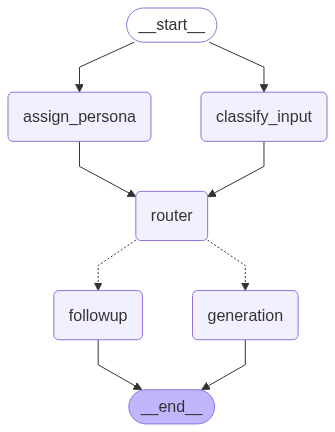

In [29]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
initial_state = { 'query': "꼬리질문해줄래?" }
graph.invoke(initial_state)


{'query': '꼬리질문해줄래?'}
available_personas_json [{'id': '042c7c16', 'type': 'other', 'name': 'Recruiter', 'interests': ['조직 적응력', '인성'], 'communication_style': '차분하고 상냥한 스타일'}, {'id': '42f9eb32', 'type': 'developer', 'name': 'CTO', 'interests': ['이슈 해결 과정과 Lessons Learned'], 'communication_style': '불필요한 말은 하지 않음, 합리적이고 이성적인 스타일'}, {'id': '62c33073', 'type': 'other', 'name': 'Recruiter', 'interests': ['조직 적응력', '인성'], 'communication_style': '차분하고 상냥한 스타일'}, {'id': '2340a562', 'type': 'developer', 'name': 'CTO', 'interests': ['이슈 해결 과정과 Lessons Learned'], 'communication_style': '불필요한 말은 하지 않음, 합리적이고 이성적인 스타일'}]


22:20:34 [INFO] httpx: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


classify_input [AIMessage(content='other', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens': 91, 'total_tokens': 92, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BhFfWDvazEgzknngkKcMXvbYaXHbB', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--b921a5ce-e1c3-4713-a8a8-be3de9c02612-0', usage_metadata={'input_tokens': 91, 'output_tokens': 1, 'total_tokens': 92, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]


22:20:37 [INFO] httpx: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


assign_persona_node Thought: The applicant's interview response is in Korean and asks for a follow-up question, which suggests a communication style that is interactive and possibly casual. The available personas include recruiters and CTOs, with the recruiters having a calm and friendly style focusing on adaptability and personality, while the CTOs are more rational and concise, focusing on issue resolution and lessons learned. The applicant seems to require interaction, indicating a need for a persona that can engage in a conversation, which aligns more with a recruiter. Both recruiters have the same interests and communication style, so selecting either would be appropriate.

Final Answer: 042c7c16


22:20:38 [INFO] httpx: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


router target='llm'
{'query': '꼬리질문해줄래?', 'input_type': 'other', 'persona_id': "Thought: The applicant's interview response is in Korean and asks for a follow-up question, which suggests a communication style that is interactive and possibly casual. The available personas include recruiters and CTOs, with the recruiters having a calm and friendly style focusing on adaptability and personality, while the CTOs are more rational and concise, focusing on issue resolution and lessons learned. The applicant seems to require interaction, indicating a need for a persona that can engage in a conversation, which aligns more with a recruiter. Both recruiters have the same interests and communication style, so selecting either would be appropriate.\n\nFinal Answer: 042c7c16", 'route_type': 'llm', 'resume': '# 토스 Python Developer 지원서\r\n\r\n## 📋 이력서\r\n\r\n### 경력 사항\r\n\r\n#### Python Backend Developer | 네이버 (2022.03 - 현재)\r\n\r\n**주요 성과:**\r\n- **복잡도 높은 Django 기반 시스템 구축**\r\n  - 월 100만+ 사용자 대상 전자상

22:20:52 [INFO] httpx: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


result ### 1단계 - 분석 (Reasoning):

지원자의 자기소개서에서 확인되는 성격/역량/행동은 다음과 같습니다:

- **고객 중심 사고**: 지원자는 "고객을 위한 최선의 선택"이라는 토스의 문화에 깊이 공감하며, 이를 내부 시스템에서부터 실현하겠다는 의지를 보이고 있습니다. 이는 토스가 추구하는 고객 중심 문화와 부합합니다.
  
- **문제 해결 능력**: 지원자는 수동 재고 관리 프로세스를 자동화하여 업무 시간을 80% 단축한 경험을 공유하며, 문제를 분석하고 해결하기 위한 체계적인 접근 방식을 강조했습니다. 이는 토스가 찾고 있는 기술적 성장과 비즈니스 문제 해결 역량과 잘 맞아떨어집니다.

- **조직 문화에 대한 이해**: 지원자는 개발자가 만드는 도구가 결국 사람에게 사용되므로, 조직 문화를 깊이 이해해야 한다고 주장했습니다. 이는 토스의 문화에 대한 관심을 반영하며, 팀워크와 협업을 중시하는 태도를 보여줍니다.

- **기술적 성장에 대한 갈망**: 기술적 완벽함보다는 상황에 맞는 최선의 선택을 추구하는 자세는, 빠르게 변화하는 환경에서 적응하는 능력을 보여줍니다.

JD에서 요구하는 자격요건, 기술, 경험과 지원자의 경력 및 프로젝트 경험은 긴밀하게 부합합니다. 지원자는 Python, Django, RESTful API 설계 및 복잡한 데이터 모델링 경험이 있으며, 이는 토스가 요구하는 기술 스택과 일치합니다. 

부족하거나 확인이 필요한 부분은, 지원자가 특정 기술 스택(예: Kafka, Kubernetes)에 대한 경험을 구체적으로 언급하지 않았다는 점입니다. 또한, 면접관으로서 지원자의 팀워크 및 협업 경험에 대한 구체적인 사례를 확인하고 싶습니다.

### 2단계 - 질문 생성 (Acting):

[생성된 면접 질문]
"자신의 기술적 성장에 대한 갈망을 잘 표현해주셨는데요, 팀워크와 협업이 중요한 환경에서 실제로 팀원들과 함께 일하면서 겪었던 도전적인 상황이나 갈등을 어떻게 해결했는지, 그 과정에서 어떤 역할을 하셨는지

{'query': '꼬리질문해줄래?',
 'answer': '### 1단계 - 분석 (Reasoning):\n\n지원자의 자기소개서에서 확인되는 성격/역량/행동은 다음과 같습니다:\n\n- **고객 중심 사고**: 지원자는 "고객을 위한 최선의 선택"이라는 토스의 문화에 깊이 공감하며, 이를 내부 시스템에서부터 실현하겠다는 의지를 보이고 있습니다. 이는 토스가 추구하는 고객 중심 문화와 부합합니다.\n  \n- **문제 해결 능력**: 지원자는 수동 재고 관리 프로세스를 자동화하여 업무 시간을 80% 단축한 경험을 공유하며, 문제를 분석하고 해결하기 위한 체계적인 접근 방식을 강조했습니다. 이는 토스가 찾고 있는 기술적 성장과 비즈니스 문제 해결 역량과 잘 맞아떨어집니다.\n\n- **조직 문화에 대한 이해**: 지원자는 개발자가 만드는 도구가 결국 사람에게 사용되므로, 조직 문화를 깊이 이해해야 한다고 주장했습니다. 이는 토스의 문화에 대한 관심을 반영하며, 팀워크와 협업을 중시하는 태도를 보여줍니다.\n\n- **기술적 성장에 대한 갈망**: 기술적 완벽함보다는 상황에 맞는 최선의 선택을 추구하는 자세는, 빠르게 변화하는 환경에서 적응하는 능력을 보여줍니다.\n\nJD에서 요구하는 자격요건, 기술, 경험과 지원자의 경력 및 프로젝트 경험은 긴밀하게 부합합니다. 지원자는 Python, Django, RESTful API 설계 및 복잡한 데이터 모델링 경험이 있으며, 이는 토스가 요구하는 기술 스택과 일치합니다. \n\n부족하거나 확인이 필요한 부분은, 지원자가 특정 기술 스택(예: Kafka, Kubernetes)에 대한 경험을 구체적으로 언급하지 않았다는 점입니다. 또한, 면접관으로서 지원자의 팀워크 및 협업 경험에 대한 구체적인 사례를 확인하고 싶습니다.\n\n### 2단계 - 질문 생성 (Acting):\n\n[생성된 면접 질문]\n"자신의 기술적 성장에 대한 갈망을 잘 표현해주셨는데요, 팀워크와 협업이 중요한 환경에서 실제로 팀원들과 함께 일하면서 겪